- Seq2Seq : 입력과 출력의 길이가 다른 데이터에서 사용
- 어텐션 : 인코더의 모든 시점에서의 은닉상태를 현재의 입력에 반영
- 토큰 : 문자를 숫자로 나타내는 방법 , 시작과 끝을 나타내는 태그가 존재
- GRU : 셀 상태를 없애고 은닉생태만 이용해서 현재의 정보를 추출

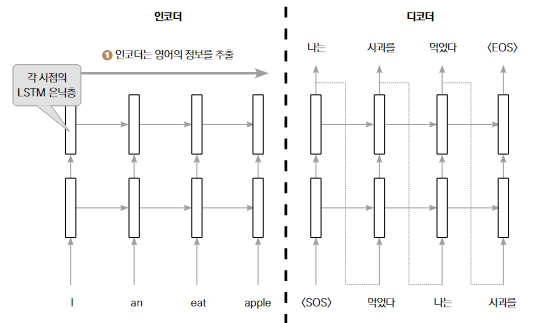

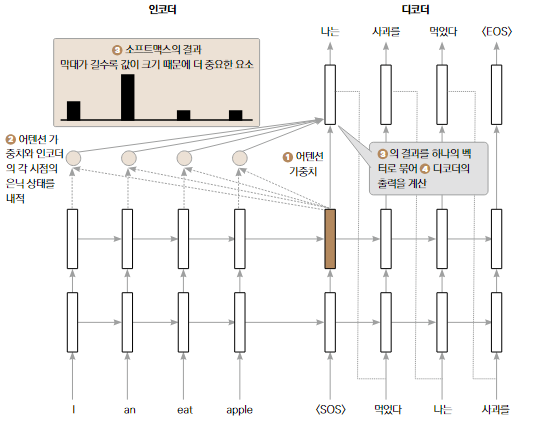

GRU(gated recurrent unit)

- LSTM을 간략화 시킨 모델, 셀 상태와 은닉생태를 통합한 모델

In [1]:
!unzip '/content/drive/MyDrive/machinelearning/kor-eng.zip'

Archive:  /content/drive/MyDrive/machinelearning/kor-eng.zip
  inflating: _about.txt              
  inflating: kor.txt                 


In [2]:
import string
li = []
with open('kor.txt','r') as kor_file:
  lines = kor_file.read().split('\n')
  for line in lines:
    # 특수문자를 지우고 모든 문자를 소문자로 변경
    txt = "".join(v for v in line if v not in string.punctuation).lower()
    li.append( '\t'.join(txt.split('\t')[:2]) )

In [3]:
li[:5]

['go\t가', 'hi\t안녕', 'run\t뛰어', 'run\t뛰어', 'who\t누구']

In [4]:
import numpy as np
import torch
from torch.utils.data.dataset import Dataset

In [5]:
def get_BOW(corpus):
  BOW = {'':0,"":1}
  for line in corpus:
    for word in line.split():
      if word not in BOW.keys():
        BOW[word] = len(BOW.keys())
  return BOW

In [6]:
get_BOW(["Tom has low blood pressure"])

{'': 1, 'Tom': 1, 'has': 2, 'low': 3, 'blood': 4, 'pressure': 5}

In [7]:
# 데이터 셋
class Eng2Kor(Dataset):
  def __init__(self,pth2txt='/content/kor.txt'):
    self.eng_corpus = []  # 영어문장이 들어가는 변수
    self.kor_corpus = []  # 한글문장이 들어가는 변수

    with open(pth2txt,'r') as f:
      lines = f.read().split("\n")
      for line in lines:
        try:
          # 특수문자를 지우고 모든 문자를 소문자로 변경
          txt = "".join(v for v in line if v not in string.punctuation).lower()
          engtxt = txt.split('\t')[0]
          kortxt = txt.split('\t')[1]

          # 길이가 10이하인 문장만 사용
          if len(engtxt.split()) <=10 and len(kortxt.split()) <= 10:
            self.eng_corpus.append(engtxt)
            self.kor_corpus.append(kortxt)
        except Exception as e:
          print(e)

    self.engBOW = get_BOW(self.eng_corpus)
    self.korBOW = get_BOW(self.kor_corpus)

  # 문장을 단어별로 분리하고 마지막에  추가
  def gen_seq(self, line):
    seq = line.split()
    seq.append("")
    return seq
  def __len__(self):
    return len(self.eng_corpus)
  def __getitem__(self, index):
    # 문자열로 되어 있는 문장을 숫자 표현으로 변경
    data =  np.array([self.engBOW[txt] for txt in self.gen_seq(self.eng_corpus[index])])
    label = np.array([self.korBOW[txt] for txt in self.gen_seq(self.kor_corpus[index])])
    return data, label

In [8]:
Eng2Kor()

list index out of range


In [9]:
def loader(dataset):
  for i in range(len(dataset)):
    data,label =  dataset[i]
    yield torch.tensor(data), torch.tensor(label)

In [10]:
temp_dataset = [(1,2),(3,4),(5,6),(7,8)]
temp_loader = loader(temp_dataset)
for data,label in temp_loader:
  print(data,label)

tensor(1) tensor(2)
tensor(3) tensor(4)
tensor(5) tensor(6)
tensor(7) tensor(8)


인코더

입력 -> 입베디드층 -> GRU층 -> 출력

In [11]:
import torch.nn as nn
class Encoder(nn.Module):
  def __init__(self, input_size , hidden_size) -> None:
    super(Encoder,self).__init__()
    self.embedding = nn.Embedding(input_size,hidden_size)
    self.gru = nn.GRU(hidden_size,hidden_size)
  def forward(self, x, h):
    # 배치 차원과 시계열 차원 추가
    x = self.embedding(x).view(1,1,-1)
    output,hidden =  self.gru(x,h)
    return output,hidden

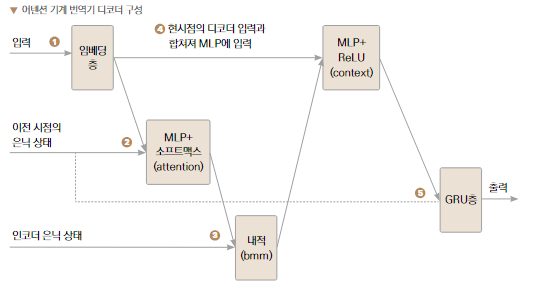

In [15]:
# 디코더
class Decoder(nn.Module):
  def __init__(self,hidden_size,output_size,drop_rate = 0.1,max_lengh = 11 ):
    super(Decoder,self).__init__()
    # 임베딩층 정의
    self.embedding = nn.Embedding(output_size,hidden_size)
    # 어텐션 가중치를 계산하기 위한 mlp 층
    self.attention = nn.Linear(hidden_size*2,max_lengh)
    # 특징 추출을 위한 mlp층
    self.context = nn.Linear(hidden_size*2,hidden_size)
    # 과적합을 피하기위해 드랍아웃층
    self.dropout = nn.Dropout(drop_rate)
    # gru층
    self.gru = nn.GRU(hidden_size,hidden_size)
    # 단어분류를 위한 mlp층
    self.out = nn.Linear(hidden_size,output_size)
    # 활성화 함수
    self.relu = nn.ReLU()
    self.softmax = nn.LogSoftmax(dim=1)
  def forward(self,x,h,encoder_outputs):
    # 1. 입력을 밀집표현
    x = self.embedding(x).view(1,1,-1)
    x = self.dropout(x)
    # 2. 어텐션의 가중치 계산
    atten_weight = self.softmax(
        self.attention(torch.cat(x[0],h[0]), -1)
    )
    # 3. 어텐션의 가중치와 인코더의 출력을 내적
    atten_applied = torch.bmm(atten_weight.unsqueeze(0),encoder_outputs.unsqueeze(0) )
    # 4. 인코더의 각 시점의 중요도와 밀집표현을 합쳐 mlp층으로 특징 추출
    output =  torch.cat( (x[0],atten_applied[0]),1 )
    output = self.context(output).unsqueeze(0)
    output = self.relu(output)
    # 5. gru층으로 입력
    output,hidden =  self.gru(output,h)
    # 6. 예측된 단어 출력
    output = self.out(output[0])
    return output

In [13]:
import random
import tqdm
from torch.optim.adam import Adam
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dataset = Eng2Kor()
encoder=Encoder(input_size=len(dataset.engBOW), hidden_size=64).to(device)
decoder=Decoder(64,len(dataset.korBOW)).to(device)
encoder_optim = Adam(encoder.parameters())
decoder_optim = Adam(decoder.parameters())

list index out of range


In [14]:
for epoch in range(2):  # 200
  iter = tqdm.tqdm(loader(dataset))
  total_loss = 0
  for data,label  in iter:
    data = torch.tensor(data, dtype = torch.long).to(device)
    label = torch.tensor(label, dtype = torch.long).to(device)
    # 인코더의 초기 은닉상태
    encoder_hidden = torch.zeros(1,1,64).to(device)
    # 인코더의 모든시점의 변수를 저장
    encoder_outputs = torch.zeros(1,1,64).to(device)  #디코더에서 인코더의 모든시점의 변수를 사용

    encoder_optim.zero_grad()
    decoder_optim.zero_grad()

    loss = 0
    # 인코더 동작
    for ei in range(len(data)):
      # 한 단어씩 인코더에 입력
      encoder_output, encoder_hidden =  encoder(data[ei],encoder_hidden)
      # 인코더의 은닉상태 저장
      encoder_outputs[ei] = encoder_output[0,0]
    decoder_input = torch.tensor([[0]]).to(device)
    # 인코더의 마지막 은닉상태를 디코더의 초기 은닉상태로 저장
    decoder_hidden = encoder_hidden

0it [00:00, ?it/s]<ipython-input-14-38228c14751a>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype = torch.long).to(device)
<ipython-input-14-38228c14751a>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype = torch.long).to(device)
0it [00:00, ?it/s]


IndexError: ignored